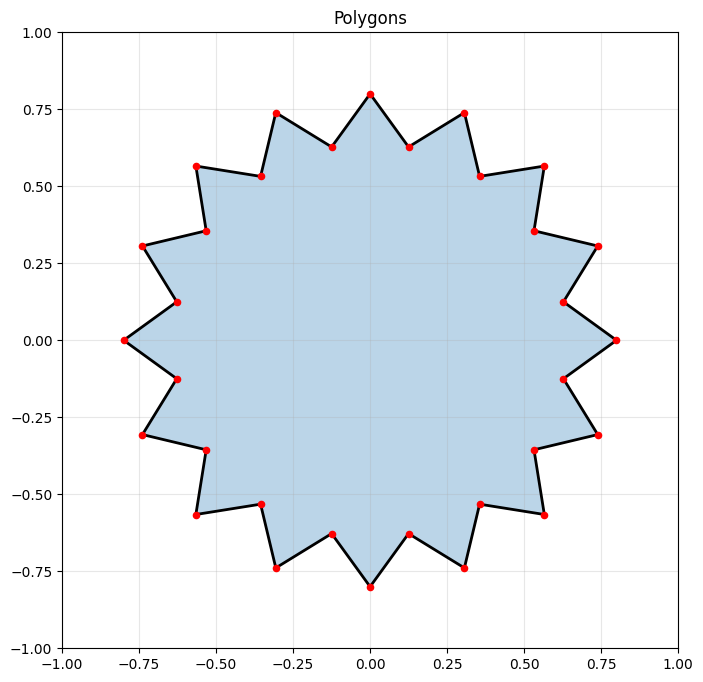

In [2]:
from dataclasses import dataclass
from ainr import generate_polygons, plot_polygons
import numpy as np

polygons = generate_polygons("1x16", convex=False, star_ratio=0.8)
plot_polygons(polygons)

@dataclass
class Surface2D:
    vertices: np.ndarray
    closed: bool

surfaces = []
for polygon in polygons:
    vertices = np.array(polygon)
    closed = True
    surface = Surface2D(vertices, closed)
    surfaces.append(surface)

In [3]:
# Find a orthogonal basis to represent part of the surface

from ainr import ReluMLP, plot_cell_sdf
import torch

mlp = ReluMLP(
    input_dim=2,
    hidden_dim=8,
    num_layers=3,
    output_dim=1,
)

# I have n surfaces, find a hyperplane that has hidden_dim

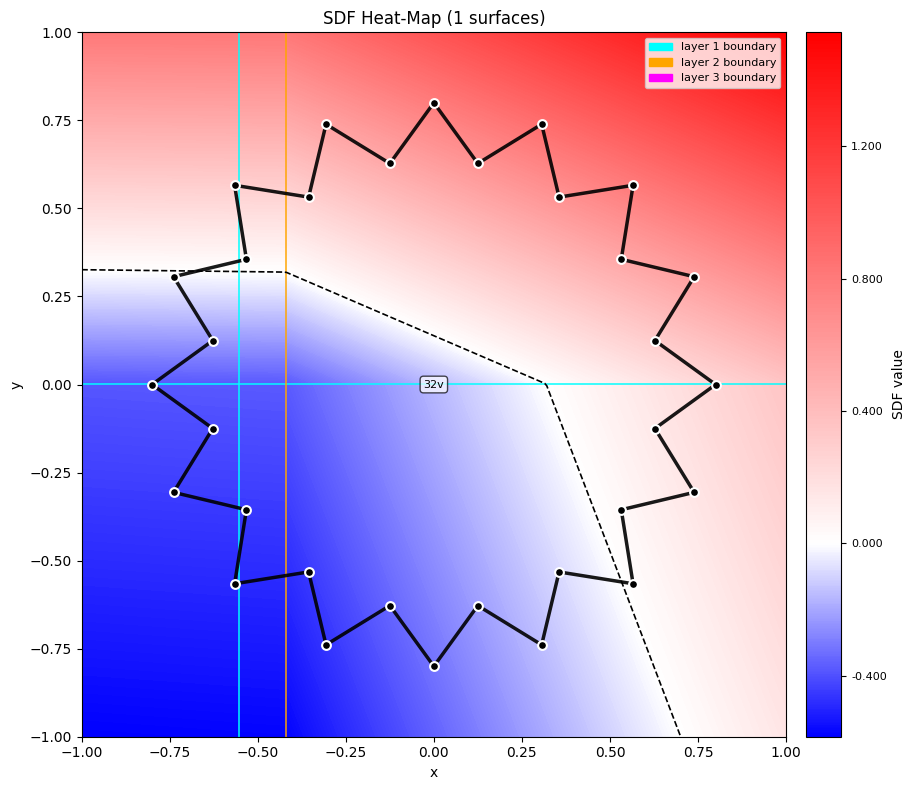

In [ ]:
from ainr import ReluMLP, plot_cell_sdf
import torch

mlp = ReluMLP(
    input_dim=2,
    hidden_dim=10,
    num_layers=3,
    output_dim=1,
)

for i in range(3):
    mlp.layers[i].weight.data = torch.zeros_like(mlp.layers[i].weight.data)

mlp.layers[0].weight.data[0, :] = torch.tensor([1, 0], dtype=torch.float32)
mlp.layers[0].weight.data[1, :] = torch.tensor([0, 1], dtype=torch.float32)

mlp.layers[1].weight.data[0, 0] = torch.tensor(1, dtype=torch.float32)
mlp.layers[1].weight.data[1, 1] = torch.tensor(1, dtype=torch.float32)

mlp.layers[2].weight.data[0, 0] = torch.tensor(1, dtype=torch.float32)
mlp.layers[2].weight.data[1, 1] = torch.tensor(1, dtype=torch.float32)

mlp.layers[3].weight.data[0, 0] = torch.tensor(0.5, dtype=torch.float32)
mlp.layers[3].weight.data[0, 1] = torch.tensor(1.0, dtype=torch.float32)
mlp.layers[3].bias.data[0] = torch.tensor(-0.5, dtype=torch.float32)

plot_cell_sdf(mlp, surfaces)

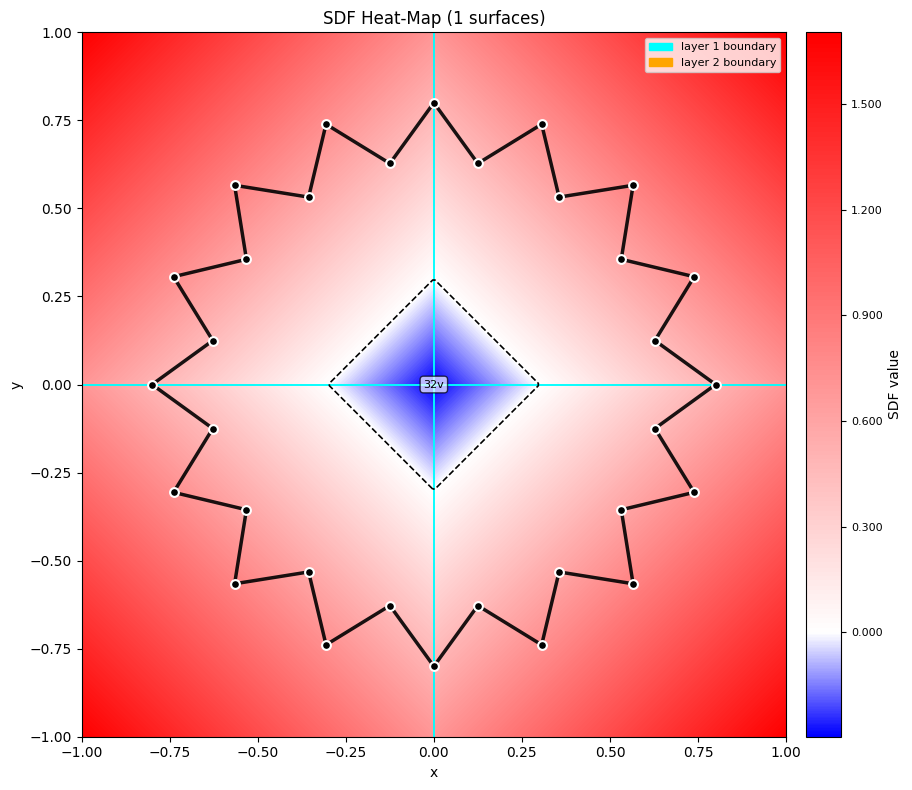

In [ ]:
from ainr import ReluMLP, plot_cell_sdf
import torch

mlp = ReluMLP(
    input_dim=2,
    hidden_dim=16,
    num_layers=2,
    output_dim=1,
)


for i in range(3):
    mlp.layers[i].weight.data = torch.zeros_like(mlp.layers[i].weight.data)
    mlp.layers[i].bias.data = torch.zeros_like(mlp.layers[i].bias.data)

mlp.layers[0].weight.data[0, :] = torch.tensor([1, 0], dtype=torch.float32)
mlp.layers[0].weight.data[1, :] = torch.tensor([0, 1], dtype=torch.float32)
mlp.layers[0].weight.data[2, :] = torch.tensor([-1, 0], dtype=torch.float32)
mlp.layers[0].weight.data[3, :] = torch.tensor([0, -1], dtype=torch.float32)

mlp.layers[1].weight.data[0, 0] = torch.tensor(1, dtype=torch.float32)
mlp.layers[1].weight.data[0, 1] = torch.tensor(1, dtype=torch.float32)

mlp.layers[1].weight.data[0, 2] = torch.tensor(1, dtype=torch.float32)
mlp.layers[1].weight.data[0, 3] = torch.tensor(1, dtype=torch.float32)

mlp.layers[2].weight.data[0, 0] = torch.tensor(1.0, dtype=torch.float32)
mlp.layers[2].bias.data[0] = torch.tensor(-0.3, dtype=torch.float32)

plot_cell_sdf(mlp, surfaces)

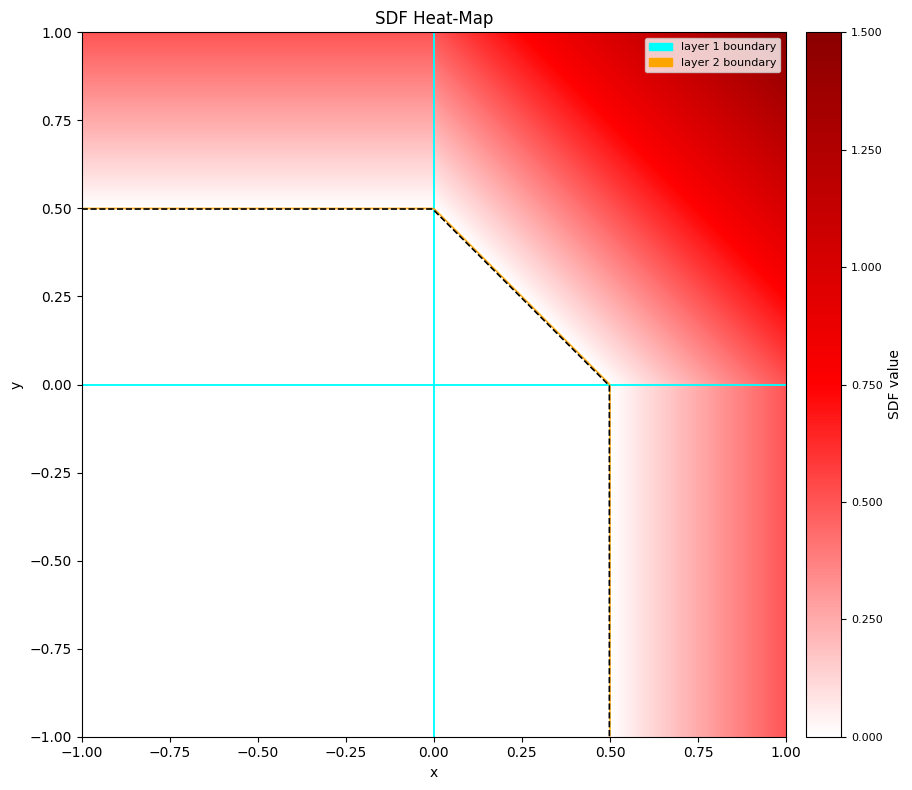

In [33]:
from ainr.model import ReluMLP
from ainr.vis import plot_cell_sdf2 as plot_cell_sdf
import torch

mlp = ReluMLP(
    input_dim=2,
    hidden_dim=16,
    num_layers=2,
    output_dim=1,
)

# Zero out all weights
for i in range(3):
    mlp.layers[i].weight.data = torch.zeros_like(mlp.layers[i].weight.data)
    mlp.layers[i].bias.data = torch.zeros_like(mlp.layers[i].bias.data)

# Layer 0: 4 axis-aligned hyperplanes
mlp.layers[0].weight.data[0, :] = torch.tensor([1, 0], dtype=torch.float32)   # +x
mlp.layers[0].weight.data[1, :] = torch.tensor([0, 1], dtype=torch.float32)   # +y
mlp.layers[0].weight.data[2, :] = torch.tensor([-1, 0], dtype=torch.float32)  # -x
mlp.layers[0].weight.data[3, :] = torch.tensor([0, -1], dtype=torch.float32)  # -y

# Layer 1: One neuron in quadrant (++) that only uses h[0] and h[1]
# This neuron is only active where x > 0 AND y > 0
mlp.layers[1].weight.data[0, 0] = 1.0  # weight for h[0] = ReLU(x)
mlp.layers[1].weight.data[0, 1] = 1.0  # weight for h[1] = ReLU(y)
mlp.layers[1].bias.data[0] = -0.5      # offset into the quadrant

# Output layer
mlp.layers[2].weight.data[0, 0] = 1.0
mlp.layers[2].bias.data[0] = 0.0

plot_cell_sdf(mlp)

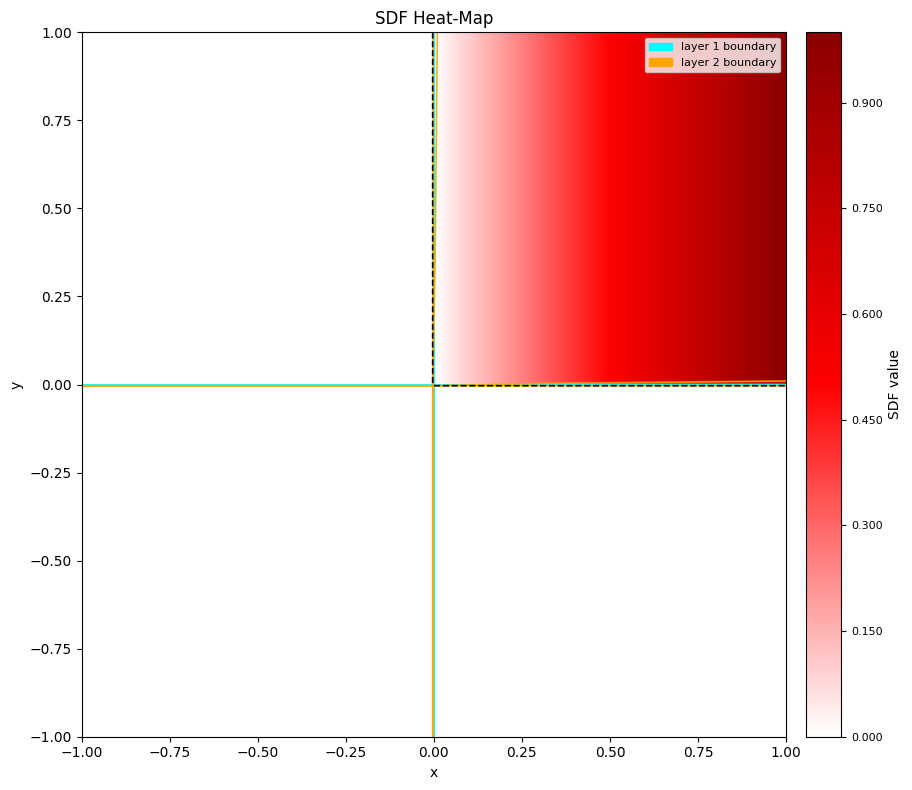

In [1]:
from ainr.model import ReluMLP
from ainr.vis import plot_cell_sdf2 as plot_cell_sdf
import torch

mlp = ReluMLP(
    input_dim=2,
    hidden_dim=16,
    num_layers=2,
    output_dim=1,
)

for i in range(3):
    mlp.layers[i].weight.data = torch.zeros_like(mlp.layers[i].weight.data)
    mlp.layers[i].bias.data = torch.zeros_like(mlp.layers[i].bias.data)

# Layer 0: standard 4 neurons
mlp.layers[0].weight.data[0, :] = torch.tensor([1, 0], dtype=torch.float32)   # h[0] = ReLU(x)
mlp.layers[0].weight.data[1, :] = torch.tensor([0, 1], dtype=torch.float32)   # h[1] = ReLU(y)
mlp.layers[0].weight.data[2, :] = torch.tensor([-1, 0], dtype=torch.float32)  # h[2] = ReLU(-x)
mlp.layers[0].weight.data[3, :] = torch.tensor([0, -1], dtype=torch.float32)  # h[3] = ReLU(-y)

M = 100.0  # Large multiplier

# Layer 1:
# g[0] = h[0]                    (pass-through x)
# g[1] = ReLU(h[0] - M*h[1])     (for x cancellation)
# g[2] = h[1]                    (pass-through y)
# g[3] = ReLU(h[1] - M*h[0])     (for y cancellation)

mlp.layers[1].weight.data[0, 0] = 1.0

mlp.layers[1].weight.data[1, 0] = 1.0
mlp.layers[1].weight.data[1, 1] = -M

mlp.layers[1].weight.data[2, 1] = 1.0

mlp.layers[1].weight.data[3, 1] = 1.0
mlp.layers[1].weight.data[3, 0] = -M

# Output: show gated_x = g[0] - g[1] = min(h[0], M*h[1])
mlp.layers[2].weight.data[0, 0] = 1.0
mlp.layers[2].weight.data[0, 1] = -1.0

plot_cell_sdf(mlp)